In [1]:
import sys
import os
import struct
import time as time
import numpy as np
import h5py
from scipy.stats import pearsonr
from itertools import chain
from scipy.io import loadmat
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import csv
from itertools import zip_longest

import src.numpy_utility as pnu
from src.plots import display_candidate_loss
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.torch_fwrf import get_value

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import DataLoader,Dataset
import argparse
import pandas as pd
from visualize import center_crop

In [2]:
# paths

parser = argparse.ArgumentParser(prog='encoding model', 
	description='input subject ID and gpu, output saved parameters',
	usage='python fwrf_ROIvoxel_mean.py --subj i --gpu j')

# parser.add_argument('--subj', type=int)
# parser.add_argument('--gpu', type=int)
# args = parser.parse_args()

nsd_root = 'Z:/CNAI2/Mansoure_NSD/'
stim_root = nsd_root + "nsd_stimuli/"
beta_root = nsd_root + "nsd_beta/"
#mask_root = nsd_root + "mask/ppdata/"
#roi_root = nsd_root + "freesurfer/"
meanROIbeta_root = nsd_root + "roiavgbeta/"

exp_design_file = nsd_root + "experiments/nsd_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"


In [3]:
# set up cuda and parameters

# test cuda
print("Cuda available?", torch.cuda.is_available())

print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
#device = torch.device("cuda:%d"%args.gpu) #cuda
device = torch.device("cuda") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)

subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'dnn_fwrf'

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/" 
#input_dir  = '/home/styvesg/repo.data/results/nsd/torch_fwrf_full_brain/S%02d/dnn_fwrf_May-10-2020_1814/'
output_dir = root_dir + "output/S%02d/%s_%s/" % (subject,model_name,timestamp) 
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print ("Time Stamp: %s" % timestamp)

exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)
subject_idx  = exp_design['subjectim']

#stim_pattern = exp_design['stimpattern']
#shared_idx   = exp_design['sharedix']
#basic_cnt    = exp_design['basiccnt']


Cuda available? True
#device: 1
device#: 0
device name: NVIDIA T400

torch: 2.1.2
cuda:  12.1
Time Stamp: Dec-21-2023_1556


In [4]:
# do not need to run again
image_data_set_all = h5py.File(stim_file, 'r')
image_data_all = np.copy(image_data_set_all['imgBrick'])
image_data_set_all.close()
print('before preprocessing',image_data_all.shape)

for k,s_idx in enumerate(subject_idx):
    s_image_data = image_data_all[s_idx - 1]
    s_image_data = np.transpose(s_image_data, (0,3,1,2))
    s_image_data = center_crop(s_image_data, 425, 227)

    save_stuff("%sS%d_stimuli_%d"%(stim_root, k+1, 227), {'stimuli': s_image_data})

before preprocessing (73000, 425, 425, 3)
saved stimuli in h5py file
saved stimuli in h5py file
saved stimuli in h5py file
saved stimuli in h5py file
saved stimuli in h5py file
saved stimuli in h5py file
saved stimuli in h5py file
saved stimuli in h5py file


In [7]:
# input image

# image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
# image_data = np.copy(image_data_set['stimuli']).astype(np.float32) / 255.
# image_data_set.close()

# load shared stimuli id
# shared_stimuli_id = pd.read_csv(stim_root + 'shared1000.txt', sep='\t', header=None)

# f = h5py.File(stim_file, 'r+')
# image_data = np.copy(f['imgBrick'][shared_stimuli_id[0]-1,:,:,:])
# f.close()

# image_data = image_data.astype(np.float32) / 255


# print (image_data.shape)
# print (image_data.dtype)
# print (np.min(image_data[0]), np.max(image_data[0]))


# image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
# image_data = np.copy(image_data_set['stimuli']).astype(np.float32) / 255.
# image_data_set.close()

# print (image_data.shape)
# print (image_data.dtype)
# print (np.min(image_data[0]), np.max(image_data[0]))



In [6]:

image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli']).astype(np.float32) / 255.
image_data_set.close()

print (image_data.shape)
print (image_data.dtype)
print (np.min(image_data[0]), np.max(image_data[0]))

trials = np.array([30000, 30000, 24000, 22500, 30000, 24000, 30000, 22500])
data_size = trials[subject-1]
ordering_data = ordering[:data_size]
shared_mask   = ordering_data<1000  # the first 1000 indices are the shared indices

val_size = np.sum(shared_mask)
trn_size = data_size - val_size
print ("Validation size =", val_size, ", Training size =", trn_size)
print(ordering_data.shape)

stim_data = image_data[ordering_data]  # reduce to only the samples available thus far

trn_stim_data = stim_data[~shared_mask]
val_stim_data = stim_data[shared_mask]

val_image_data = image_data[:1000]

print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

Validation size = 3000 , Training size = 27000
(30000,)
cudnn: 8801
dtype: torch.float32


In [8]:
# load beta

ROIs = ['OFA', 'FFA1', 'FFA2', 'mTLfaces', 'aTLfaces', 'EBA', 'FBA1', 'FBA2', 'mTLbodies', 'OPA', 'PPA', 'RSC', 'OWFA', 'VWFA1', 'VWFA2', 'mfswords', 'mTLwords', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
#ROIs = ['L_hippocampus', 'L_amygdala', 'R_hippocampus', 'R_amygdala']
roi_num = len(ROIs)
roi_data = np.zeros([data_size, roi_num])
n = 0
del_idx = []
for roi in ROIs:
    roi_data[:,n] = np.genfromtxt(meanROIbeta_root + 'subj%02d/meanbeta_'%subject + roi + '.txt')
    if np.isnan(np.sum(roi_data[:,n])):
    	del_idx.append(n)
    n += 1

roi_data = np.delete(roi_data, del_idx, axis=1)

trn_roi_data = roi_data[~shared_mask]
val_roi_data = roi_data[shared_mask]


In [9]:

# load feature maps
from torchmodel.models.alexnet import Alexnet_fmaps
_fmaps_fn = Alexnet_fmaps().to(device)

_x = torch.tensor(image_data[:100]).to(device) # the input variable.
_fmaps = _fmaps_fn(_x)
for k,_fm in enumerate(_fmaps):
    print (_fm.size())

from src.torch_feature_space import filter_dnn_feature_maps

# I used image_data because the repeats are not relevant
_fmaps_fn, lmask, fmask, tuning_masks = filter_dnn_feature_maps(image_data, _fmaps_fn, batch_size=100, fmap_max=512)

_x = torch.tensor(image_data[:100]).to(device) # the input variable.
_fmaps = _fmaps_fn(_x)
for k,_fm in enumerate(_fmaps):
    print (_fm.size())

from src.rf_grid    import linspace, logspace, model_space, model_space_pyramid
from src.torch_fwrf import learn_params_ridge_regression, get_predictions

aperture = np.float32(1)
nx = ny = 11
smin, smax = np.float32(0.04), np.float32(0.4)
ns = 8

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
#model_specs = [[(0., aperture*1.1), (0., aperture*1.1), (smin, smax)], [linspace(nx), linspace(ny), logspace(ns)]]
#models = model_space(model_specs)
models = model_space_pyramid(logspace(ns)(smin, smax), min_spacing=1.4, aperture=1.1*aperture)
print ('candidate count = ', len(models))

sample_batch_size = 200
voxel_batch_size = 500
holdout_size = 3000
lambdas = np.logspace(3.,7.,9, dtype=np.float32)
#_log_act_func = lambda _x: torch.log(1 + torch.abs(_x))*torch.tanh(torch.abs(_x))




torch.Size([100, 64, 27, 27])
torch.Size([100, 192, 27, 27])
torch.Size([100, 384, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 4096, 1, 1])
torch.Size([100, 4096, 1, 1])
torch.Size([100, 1000, 1, 1])


100it [01:05,  1.52it/s]

layer: 0, shape=(100, 64, 27, 27)
layer: 1, shape=(100, 192, 27, 27)
layer: 2, shape=(100, 384, 13, 13)
layer: 3, shape=(100, 256, 13, 13)
layer: 4, shape=(100, 256, 13, 13)
layer: 5, shape=(100, 512, 1, 1)
layer: 6, shape=(100, 512, 1, 1)
layer: 7, shape=(100, 512, 1, 1)

fmaps: 0, shape=(100, 256, 27, 27)
fmaps: 1, shape=(100, 896, 13, 13)
fmaps: 2, shape=(100, 1536, 1, 1)


torch.Size([100, 256, 27, 27])
torch.Size([100, 896, 13, 13])
torch.Size([100, 1536, 1, 1])
candidate count =  875
trn_size = 24000 (88.9%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [21]:
from torch_fwrf import learn_params_ridge_regression, get_predictions, Torch_fwRF_voxel_block

best_losses, best_lambdas, best_params = learn_params_ridge_regression(
    trn_stim_data, trn_roi_data, _fmaps_fn, models, lambdas, \
    aperture=aperture, _nonlinearity=None, zscore=True, sample_batch_size=sample_batch_size, \
    voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, shuffle=False, add_bias=True)

print ([p.shape if p is not None else None for p in best_params])
param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params]
_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, _nonlinearity=None, input_shape=image_data.shape, aperture=1.0)


trn_size = 24000 (88.9%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([200, 256, 27, 27])
torch.Size([200, 896, 13, 13])
torch.Size([200, 1536, 1, 1])
---------------------------------------

model  874 of 875 , voxels [     0:21    ] of 22
---------------------------------------
total time = 464835.001269s
total throughput = 21128.863694s/voxel
voxel throughput = 1740.312481s/voxel
setup throughput = 487.483573s/model
[(22, 3), (22, 2688), (22,), (22, 2688), (22, 2688)]


In [26]:
# test some results
val_voxel_pred.shape

(3000, 22)

In [23]:
# predict and evaluate

voxel_pred = get_predictions(val_image_data, _fmaps_fn, _fwrf_fn, best_params, sample_batch_size=sample_batch_size)

val_voxel_pred = voxel_pred[ordering[:data_size][shared_mask]]
val_cc  = np.zeros(shape=(val_voxel_pred.shape[1]))
for v in tqdm(range(val_voxel_pred.shape[1])):    
    val_cc[v] = np.corrcoef(val_roi_data[:,v], val_voxel_pred[:,v])[0,1]  
val_cc = np.nan_to_num(val_cc)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_params = {
    'lmask': lmask,
    'fmask': fmask,
    'tuning_masks': tuning_masks,
    'aperture': aperture,
    #'voxel_mask': voxel_mask,
    #'brain_nii_shape': np.array(brain_nii_shape),
    'val_size': val_size,
    'trn_size': trn_size,
    'shared_mask': shared_mask,
    'image_order': ordering_data,
    #'voxel_index': voxel_idx,
    #'voxel_roi': voxel_roi,
    'params': best_params,
    'lambdas': lambdas, 
    'best_lambdas': best_lambdas,
    'val_cc': val_cc,
    }

print (timestamp)


100%|██████████| 22/22 [00:00<00:00, 916.21it/s]

Dec-21-2023_1556


saved lmask@0 in h5py file
saved lmask@1 in h5py file
saved lmask@2 in h5py file
saved fmask@0 in h5py file
saved fmask@1 in h5py file
saved fmask@2 in h5py file
saved tuning_masks@0 in h5py file
saved tuning_masks@1 in h5py file
saved tuning_masks@2 in h5py file
saved tuning_masks@3 in h5py file
saved tuning_masks@4 in h5py file
saved tuning_masks@5 in h5py file
saved tuning_masks@6 in h5py file
saved tuning_masks@7 in h5py file
saved aperture in h5py file
saved val_size in h5py file
saved trn_size in h5py file
saved shared_mask in h5py file
saved image_order in h5py file
saved params@0 in h5py file
saved params@1 in h5py file
saved params@2 in h5py file
saved params@3 in h5py file
saved params@4 in h5py file
saved lambdas in h5py file
saved best_lambdas in h5py file
saved val_cc in h5py file


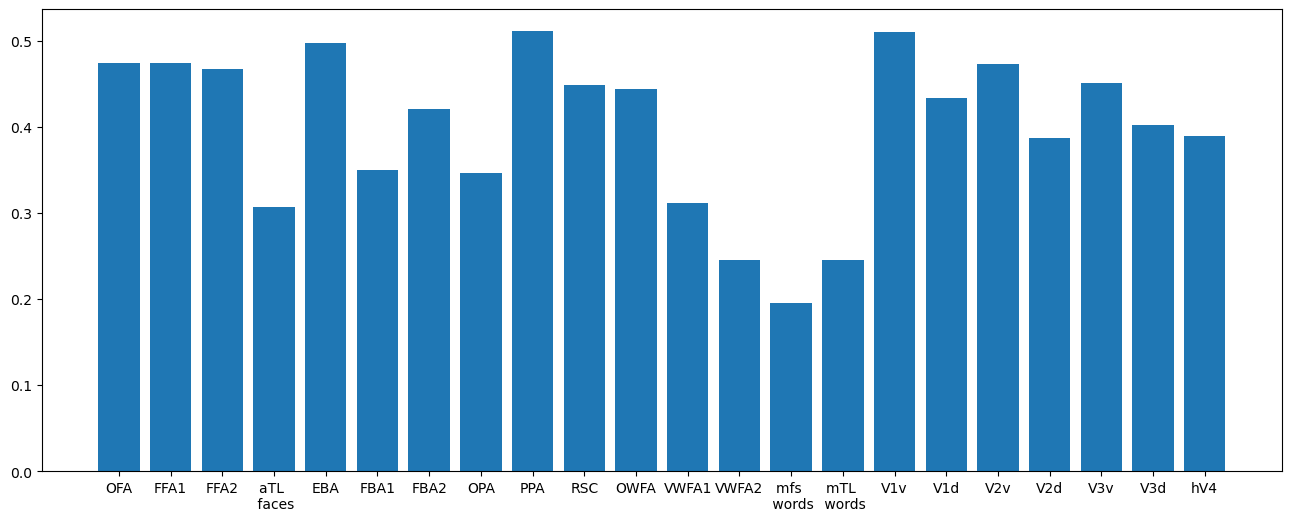

In [24]:
# save results

save_dir = root_dir + "myoutput/S%02d/%s_%s/" % (subject,model_name,timestamp) 
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_stuff(save_dir + "model_params", flatten_dict(model_params))

ROIs_label = ['OFA', 'FFA1', 'FFA2', 'mTL \n faces', 'aTL \n faces', 'EBA', 'FBA1', 'FBA2', 'mTL \n bodies', 'OPA', 'PPA', 'RSC', 'OWFA', 'VWFA1', 'VWFA2', 'mfs \n words', 'mTL \n words', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
#ROIs_label = ['L_hippocampus', 'L_amygdala', 'R_hippocampus', 'R_amygdala']
ROIs_label = np.delete(ROIs_label,del_idx) 
plt.figure(figsize=(16,6))
plt.bar(ROIs_label,val_cc)
plt.savefig(save_dir + 'acc.png')